### Table of Contents

* [Imports](#Imports)
* [Load Data](#Load_Data)
* [Data preparation](#Data_preparation)
* [Data visualization](#Data_visualization)
    * [budget, revenue, profit](#budget_revenue_profit)
    * [genres](#genres)
    * [keywords](#keywords)
    * [original_language](#original_language)
    * [production_countries](#production_countries)
    * [production_companies](#production_companies)
    * [cast](#cast)
    * [release_year, release_month](#release_year_release_month)
    * [correlation](#correlation)
* [Recommender systems](#Recommender_systems)
    * [Weighted average](#Weighted_average)
    * [Content based](#Content_based)
    * [Content based with more features](#Content_based_with_more_features)

# **Imports** <a class="anchor" id="Imports"></a>

In [ ]:
%%capture
!pip install pandas-profiling;
!pip install wordcloud
!pip install squarify
!pip install pywaffle

In [ ]:
from collections import defaultdict, Counter
from functools import partial
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
from pandas_profiling import ProfileReport
from pywaffle import Waffle
import squarify
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from wordcloud import WordCloud

pd.set_option("display.max_columns", None)
%matplotlib inline

# **Load Data** <a class="anchor" id="Load_Data"></a>

In [ ]:
PATH = "../input/tmdb-movie-metadata"
print(os.listdir(PATH))

In [ ]:
credit = pd.read_csv(os.path.join(PATH, 'tmdb_5000_credits.csv'))
movie = pd.read_csv(os.path.join(PATH, 'tmdb_5000_movies.csv'))

In [ ]:
credit.head(1)

In [ ]:
movie.head(1)

In [ ]:
# merge this two dataset
credit.columns = ['id','tittle','cast','crew']
movie_df = movie.merge(credit, on='id')
del movie
del credit

In [ ]:
movie_df.head(1)

# **Data preparation** <a class="anchor" id="Data_preparation"></a>

In [ ]:
# # the fastest way to get familiarize dataset and see much information
report = ProfileReport(movie_df)
report

In [ ]:
# convert date appropriate format
movie_df["release_date"] = pd.to_datetime(movie_df['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df['release_month'] = movie_df['release_date'].dt.month_name()
del movie_df["release_date"]
movie_df.head(1)

In [ ]:
# transform all columns which had json string into json format
# several columns has id and name
# leave only name for them beacause id is not so important in this case
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries', 
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew": # We need other information besides the name
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])
movie_df.head(1)

In [ ]:
yes = movie_df['crew']
yes[0]

In [ ]:
# create director writer and producer columns 
def get_job(job, row):
    person_name = [x['name'] for x in row if x['job']==job] 
    return person_name[0] if len(person_name) else np.nan

movie_df["director"] = movie_df["crew"].apply(partial(get_job, "Director"))
movie_df["writer"]   = movie_df["crew"].apply(partial(get_job, "Writer"))
movie_df["producer"] = movie_df["crew"].apply(partial(get_job, "Producer"))
del movie_df["crew"]

# create profit column
movie_df["profit"] = movie_df["revenue"] - movie_df["budget"]
movie_df.head(1)

In [ ]:
missing_data = movie_df.isnull().sum()
missing_data

In [ ]:
# fill some missing values by most frequent one
for col in ["runtime", "release_year", "release_month"]:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])

In [ ]:
movie_df.head(2)

# **Data visualization** <a class="anchor" id="Data_visualization"></a>

## budget, revenue, profit <a class="anchor" id="budget_revenue_profit"></a>

In [ ]:
top_movie_num = 10
top_movies_based_on = ["budget", "revenue", "profit", "vote_average", "vote_count", "popularity"]

fig, ax = plt.subplots(len(top_movies_based_on)//3, 3, figsize=(30,14))
colors = plt.cm.get_cmap('viridis', top_movie_num)

for i, col in enumerate(top_movies_based_on):
    top_movies_by = movie_df.sort_values(by=[col], ascending=False).head(top_movie_num)
    r, c = i//3, i%3
    ax[r][c].barh(top_movies_by["title"], top_movies_by[col], color=colors.colors)
    ax[r][c].set_title(f"top movies based on {col}", fontsize=24, pad=20)
    ax[r][c].tick_params(axis='both', which='major', labelsize=16)
    ax[r][c].invert_yaxis()    
    
plt.suptitle('Top movies based on some features',fontsize=30, y=1)
fig.tight_layout()

### genres <a class="anchor" id="genres"></a>

In [ ]:
# plot genre frequncy with treemap 
genres_flatten = sum(movie_df["genres"].values, []) # genres are list of lists
genres_info = Counter(genres_flatten)
genres_info

plt.figure(figsize=(15, 10))
plt.title("Genres", fontsize=25, pad=20)
squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':12}, bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

In [ ]:
fig, ax = plt.subplots()
ax.pie(genres_info.values(), labels = genres_info.keys())
ax.set_title("Genres")
plt.show()

### keywords <a class="anchor" id="keywords"></a>

In [ ]:
top_keywords_num = 30
keywords_flatten = sum(movie_df["keywords"].values, []) # keywords are list of lists
keywords_info = Counter(keywords_flatten)
top_keywords = dict(keywords_info.most_common(top_keywords_num))

plt.figure(figsize=(20, 6))
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18, labelpad=10)
plt.bar(top_keywords.keys(), top_keywords.values(), align='center', color=plt.cm.get_cmap('plasma', top_keywords_num).colors)
plt.title("Keywords popularity", fontsize=25, pad=20)
plt.show()

### original_language <a class="anchor" id="original_language"></a>

In [ ]:
# plot unique cast frequency
language_info = movie_df["original_language"].value_counts()[:50]
language_info

wordcloud = WordCloud(background_color='black')
wordcloud.generate_from_frequencies(dict(language_info))

plt.figure(figsize=(15,10))
plt.title("original language", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

### production_countries <a class="anchor" id="production_countries"></a>

In [ ]:
top_contries_num = 10
production_contries_flatten = sum(movie_df["production_countries"].values, []) # production_countries are list of lists
production_contries_info = Counter(production_contries_flatten)
top_production_contries = production_contries_info.most_common(top_contries_num)

plt.figure(figsize=(30, 8))
plt.xticks(rotation=65, fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18)
plt.title("Production countries", fontsize=25, pad=20)
plt.bar(dict(top_production_contries).keys(), dict(top_production_contries).values(), color=plt.cm.get_cmap('cividis', top_contries_num).colors);

### production_companies <a class="anchor" id="production_companies"></a>

In [ ]:
production_companies_flatten = sum(movie_df["production_companies"].values, []) # production_companies are list of lists
production_companies_info = Counter(production_companies_flatten)
top_production_companies = production_companies_info.most_common(10)

fig = plt.figure(
    FigureClass=Waffle, 
    rows=30, 
    values=dict(top_production_companies), 
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='child', icon_size=14, 
    icon_legend=True,
    figsize=(24,8)
)

### cast <a class="anchor" id="cast"></a>

In [ ]:
# plot unique cast frequency
cast_flatten = sum(movie_df["cast"].values, []) # cast are list of lists
cast_info = Counter(cast_flatten)

wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(dict(cast_info.most_common(50)))

plt.figure(figsize=(15,10))
plt.title("Cast", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

### release_year, release_month <a class="anchor" id="release_year_release_month"></a>

In [ ]:
plt.xticks(fontsize=12)
plt.ylabel("Nb. of occurences", fontsize=14)
plt.title("Movie release year", fontsize=25, pad=20)
plt.hist(movie_df["release_year"], bins=100)
plt.figure(figsize=(15,5))

In [ ]:
fig, ax  = plt.subplots(1,2,figsize = (16,8))
fig.suptitle('Movie count in year and month', fontsize=20)

movie_count_in_10th_year = movie_df["release_year"].dropna().apply(lambda x:str(int(x)//10*10)+'s').value_counts()
movie_count_in_month = movie_df["release_month"].value_counts()
    
movie_count_in_10th_year.plot.pie(title='Distribution of Graduated', ax=ax[0], autopct="%.2f")
movie_count_in_month.plot.pie(title='Distribution of Graduated', ax=ax[1], autopct="%.2f")
fig.tight_layout()

### correlation <a class="anchor" id="correlation"></a>

In [ ]:
matrix = movie_df[["budget", "popularity", "revenue", "runtime", "vote_average", "vote_count"]].corr()

f, ax = plt.subplots(figsize=(12, 10))
plt.title("correlation between features", fontsize=20, pad=20)
plt.xticks(range(len(matrix.index)), matrix.index, fontsize=12)
plt.yticks(range(len(matrix.index)), matrix.index, fontsize=12)

# adding values
for i in range(len(matrix.index)):
    for j in range(len(matrix.index)):
        text = ax.text(j, i, round(matrix.iloc[i, j],3), ha="center", va="center", color="w", fontsize=12)
        
plt.imshow(matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar();

# **Recommender System** <a class="anchor" id="Recommender_systems"></a>

### Weighted Average <a class="anchor" id="Weighted_average"></a>

![](https://image.ibb.co/jYWZp9/wr.png)

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

- We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

In [ ]:
C = movie_df['vote_average'].mean()
m = movie_df['vote_count'].quantile(0.9)
q_movies = movie_df.copy().loc[movie_df['vote_count'] >= m]
C, m, q_movies.shape

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(5)

In [ ]:
# with open('../data/movie_scores.pickle', 'wb') as handle:
#     pickle.dump(q_movies[['id', 'title','score']], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Content based <a class="anchor" id="Content_based"></a>

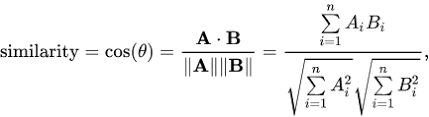

In [ ]:
movie_df['overview'].head(3)

In [ ]:
movie_df['overview'] = movie_df['overview'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_df['overview'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()

tfidf_matrix.shape

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]

    return pd.DataFrame(zip(movie_df['title'].iloc[movie_indices], movie_similarity), columns=["title", "similarity"])

In [ ]:
get_recommendations('The Godfather: Part II')

In [ ]:
get_recommendations('The Avengers')

In [ ]:
get_recommendations('Pulp Fiction')

In [ ]:
# # save data for future use
# scipy.sparse.save_npz('../data/tfidf_matrix.npz', tfidf_matrix)

# with open('../data/movie_df.pickle', 'wb') as handle:
#     pickle.dump(movie_df[["id","title"]], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Content based with more features <a class="anchor" id="Content_based_with_more_features"></a>

In [ ]:
# leave only top values for some features
# for example we dont need to take all casts
features = ['cast', 'keywords', 'genres']
top_num = 5
for feature in features:
    movie_df[feature] = movie_df[feature].apply(lambda x: x[:top_num] if isinstance(x, list) else [])

In [ ]:
# remove spaces for some features
# because we don't need "Johnny Depp" and "Johnny Galecki" as the same
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''
    
features = ['cast', 'keywords', 'genres', 'director', "writer", "producer", "production_companies", "production_countries"]

for feature in features:
    movie_df[feature] = movie_df[feature].apply(clean_data)

In [ ]:
def create_joined_features(x):
    return ' '.join([' '.join(x[f]) if isinstance(x[f], list) else str(x[f]) for f in features])

movie_df["join_features"] = movie_df.apply(create_joined_features, axis=1)

In [ ]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie_df['join_features'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
movie_df = movie_df.reset_index()
indices = pd.Series(movie_df.index, index=movie_df['title'])

count_matrix.shape

In [ ]:
get_recommendations('The Godfather: Part II', cosine_sim2)

In [ ]:
get_recommendations('The Avengers', cosine_sim2)

In [ ]:
get_recommendations('Pulp Fiction', cosine_sim2)

In [ ]:
# # save matrix for future use
# scipy.sparse.save_npz('../data/count_matrix.npz', count_matrix)